# Primary Model Pipeline Applied to 5 Segment Large Dataset

In [1]:
import collections
import pandas as pd
import numpy as np
import time
import os
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 500)

In [2]:
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

In [3]:
tf.__version__

'2.0.0'

### Load Datasets and Clean
In this configuration the relevant data set should be loaded from the same folder as the notebook

In [4]:
df = pd.read_csv('jackson_megadata_10_23.csv')

The data consists of timestamps from the two hardware devices and a diff between them. When the two hardware data streams were stitched together an effor was made to minimize this diff, but the driver configuration did not easily permit eliminating it. This information is included to understand the accuracy of the data, but will not be used during the training.

The time data is followed by the 8 channels from the Myo, this data will be used as input features.

This is followed by the 63 positional points from the Leap cameras. These will be used as labels.

In [5]:
df.head()

,Unnamed: 0,Leap timestamp,timestamp diff,emg timestamp,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8,Wrist x,Wrist y,Wrist z,Thumb Proximal x,Thumb Proximal y,Thumb Proximal z,Thumb Intermediate x,Thumb Intermediate y,Thumb Intermediate z,Thumb Distal x,Thumb Distal y,Thumb Distal z,Thumb Tip x,Thumb Tip y,Thumb Tip z,Index Proximal x,Index Proximal y,Index Proximal z,Index Intermediate x,Index Intermediate y,Index Intermediate z,Index Distal x,Index Distal y,Index Distal z,Index Tip x,Index Tip y,Index Tip z,Middle Proximal x,Middle Proximal y,Middle Proximal z,Middle Intermediate x,Middle Intermediate y,Middle Intermediate z,Middle Distal x,Middle Distal y,Middle Distal z,Middle Tip x,Middle Tip y,Middle Tip z,Ring Proximal x,Ring Proximal y,Ring Proximal z,Ring Intermediate x,Ring Intermediate y,Ring Intermediate z,Ring Distal x,Ring Distal y,Ring Distal z,Ring Tip x,Ring Tip y,Ring Tip z,Pinky Proximal x,Pinky Proximal y,Pinky Proximal z,Pinky Intermediate x,Pinky Intermediate y,Pinky Intermediate z,Pinky Distal x,Pinky Distal y,Pinky Distal z,Pinky Tip x,Pinky Tip y,Pinky Tip z
0,0,1.571862e+09,0.006472,1.571862e+09,56.0,152.0,318.0,58.0,30.0,26.0,37.0,168.0,27.481928,0.635315,44.404579,3.819370,-10.501190,57.583588,-39.021576,-14.662689,37.134148,-69.938087,-15.536011,26.992786,-90.684303,-16.765839,18.792263,-31.480103,3.195557,-11.996174,-48.617424,12.979187,-47.950493,-56.789734,2.440277,-66.780174,-59.230820,-12.140320,-73.670944,-12.269012,5.741394,-20.408253,-26.628906,19.429688,-61.925949,-36.830482,8.192657,-84.433563,-41.600212,-7.619537,-91.437363,9.305349,5.784424,-23.192884,-1.900085,17.207031,-62.730690,-11.677986,6.098206,-84.647568,-17.221012,-9.363892,-91.600197,29.291636,1.544373,-23.824600,22.835503,5.419800,-56.729340,17.429138,2.168213,-74.302849,11.652407,-4.481842,-88.201462
1,1,1.571862e+09,-0.017444,1.571862e+09,54.0,164.0,301.0,148.0,43.0,29.0,36.0,169.0,26.647976,-0.541893,44.900626,2.603665,-11.599823,57.431037,-39.666034,-14.301682,35.652349,-70.089661,-14.468178,24.132261,-90.578381,-15.055008,15.274604,-31.203072,3.832390,-12.509948,-47.597781,14.169205,-48.651957,-55.505336,3.798073,-67.685915,-57.910363,-10.747452,-74.662590,-11.808361,6.275238,-20.517360,-25.454881,20.207542,-62.191739,-35.418246,9.399536,-85.011818,-40.310819,-6.143776,-92.508541,9.811148,6.081985,-22.903098,-0.553401,17.576523,-62.645160,-9.981847,6.514847,-84.736057,-15.500547,-8.887718,-91.833954,29.747767,1.589165,-23.245819,24.140824,6.374512,-56.173798,19.047623,3.444153,-73.894844,13.431637,-3.077950,-87.919249
2,2,1.571862e+09,0.003166,1.571862e+09,50.0,161.0,401.0,184.0,49.0,32.0,37.0,162.0,25.490219,-3.977844,45.407623,0.888691,-15.207642,56.645126,-40.799980,-12.787781,33.687691,-70.586067,-9.926239,20.879833,-91.010010,-7.984314,12.033489,-30.784788,5.359344,-12.988110,-46.170105,17.185913,-49.120426,-53.684822,7.380035,-68.608513,-56.010406,-6.984161,-75.977188,-11.141672,7.823792,-20.362720,-23.704641,23.463989,-61.773483,-33.332466,13.942474,-85.301781,-38.390213,-0.982178,-93.875229,10.523100,7.254333,-22.239563,1.277081,20.302490,-61.781082,-7.774546,10.311188,-84.531990,-13.392775,-4.599304,-92.547852,30.355955,2.308136,-22.387161,26.408840,10.257629,-54.954762,21.679298,8.039429,-72.880737,16.065914,1.318481,-86.812164
3,3,1.571862e+09,0.010059,1.571862e+09,40.0,170.0,451.0,206.0,52.0,32.0,28.0,82.0,25.153648,-5.140533,45.478523,0.395868,-16.426270,56.309441,-41.075424,-11.990051,33.259583,-70.632256,-7.888000,20.259293,-91.043556,-4.950928,11.661678,-30.656673,5.864960,-13.072382,-45.760315,17.912903,-49.250374,-53.120193,8.142944,-68.815437,-55.381058,-6.207825,-76.230270,-10.946850,8.341492,-20.262655,-23.150558,24.345184,-61.641949,-32.622368,15.204285,-85.383560,-37.708450,0.511047,-94.331711,10.725384,7.651855,-22.008507,1.703369,20.909332,-61.532143,-7.254799,11.117615,-84.406494,-12.890709,-3.660126,-92.652481,30.522303,2.563080,-22.131792,27.211058,11.719635,-54.452309,22.549606,9.592224,-72.407104,16.8547

In [38]:
df = df.drop(labels=["Leap timestamp", "timestamp diff", "emg timestamp"], axis=1)
df = df.drop(df.columns[0], axis=1)

In [39]:
df.describe()

,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8,Wrist x,Wrist y,Wrist z,Thumb Proximal x,Thumb Proximal y,Thumb Proximal z,Thumb Intermediate x,Thumb Intermediate y,Thumb Intermediate z,Thumb Distal x,Thumb Distal y,Thumb Distal z,Thumb Tip x,Thumb Tip y,Thumb Tip z,Index Proximal x,Index Proximal y,Index Proximal z,Index Intermediate x,Index Intermediate y,Index Intermediate z,Index Distal x,Index Distal y,Index Distal z,Index Tip x,Index Tip y,Index Tip z,Middle Proximal x,Middle Proximal y,Middle Proximal z,Middle Intermediate x,Middle Intermediate y,Middle Intermediate z,Middle Distal x,Middle Distal y,Middle Distal z,Middle Tip x,Middle Tip y,Middle Tip z,Ring Proximal x,Ring Proximal y,Ring Proximal z,Ring Intermediate x,Ring Intermediate y,Ring Intermediate z,Ring Distal x,Ring Distal y,Ring Distal z,Ring Tip x,Ring Tip y,Ring Tip z,Pinky Proximal x,Pinky Proximal y,Pinky Proximal z,Pinky Intermediate x,Pinky Intermediate y,Pinky Intermediate z,Pinky Distal x,Pinky Distal y,Pinky Distal z,Pinky Tip x,Pinky Tip y,Pinky Tip z
count,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000
mean,69.830650,194.624456,327.642768,71.728214,44.296870,87.210112,73.443849,95.129351,13.433740,-9.918895,49.406393,-11.376644,-25.605264,51.338970,-44.872333,-24.645973,18.824727,-61.431829,-24.770864,-7.855166,-77.766978,-23.818628,-20.041394,-27.111190,4.681878,-20.149181,-31.168010,2.216711,-56.533035,-31.400229,-3.194320,-73.436094,-30.786220,-7.652179,-83.590116,-6.693581,10.463009,-21.165028,-6.515101,11.520539,-63.206372,-5.261173,7.249119,-84.549727,-3.946629,3.396960,-96.981908,14.726588,12.407608,-16.884533,16.900805,11.061808,-56.082492,18.437839,4.973580,-76.538139,19.668363,-0.382871,-88.293062,34.624458,9.507856,-12.152019,44.629017,11.456136,-40.051041,49.475038,9.713231,-53.828391,53.471617,7.140140,-64.891697
std,52.362277,117.678324,202.985681,44.448922,36.061338,141.084668,73.084319,68.073366,11.101877,9.608523,5.131227,12.637440,11.062260,5.787927,11.626375,7.278401,10.328375,15.079041,12.786336,15.241664,21.838932,17.859002,19.772263,4.206371,4.495053,6.532463,13.169467,20.142673,11.303510,17.535305,30.724830,20.110927,20.610897,36.878668,29.311201,4.934637,4.187734,2.722228,14.825448,20.637099,8.213241,19.314485,33.083783,18.344533,21.852345,39.955083,27.991373,4.647071,4.449165,4.145501,14.127276,19.079015,6.454849,19.054060,31.085150,15.175452,21.861600,38.290924,24.522839,4.250847,5.660208,7.977864,13.918032,17.930563,10.334027,19.450786,26.805241,12.623608,24.040729,34.119182,17.605140
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-18.788593,-47.219574,0.000000,-45.582393,-60.541901,0.000000,-64.980680,-66.381989,-11.942673,-85.509727,-81.291138,-44.110306,-107.789253,-91.676575,-66.343353,-35.445511,-20.730328,-32.883482,-71.428963,-58.541824,-73.250750,-92.259822,-77.042549,-96.800034,-107.166021,-91.046356,-113.517113,-22.855350,-12.155167,-25.658291,-56.705952,-56.844780,-73.379822,-75.681870,-79.146027,-101.507748,-89.119637,-95.912731,-120.184189,-7.060419,-11.240997,-26.

## Autoencoder
The final pipeline will pass the data into an LSTM and then into an autoencoder to expand features into the 63 point space. This autoencoder will be trained first below:

In [8]:
feature_ar = df.loc[:, 'ch1':'ch8'].values
label_ar = df.loc[:, 'Wrist x':].values

In [9]:
feature_ar.shape

(410705, 8)

In [10]:
label_ar.shape

(410705, 63)

Build the autoencoder structure:

In [11]:
encoding_dim = 9 #dimensionality of 'feature' vector

a_fn = None

# Full autoencoder
input_vec = Input(shape=(63,))
dense_0 = Dense(32, activation=a_fn)(input_vec)
dense_1 = Dense(16, activation=a_fn)(dense_0)
encoded = Dense(encoding_dim, activation=a_fn)(dense_1)
dense_2 = Dense(32, activation=a_fn, name='decoder_0')(encoded)
dense_3 = Dense(16, activation=a_fn, name='decoder_1')(dense_2)
decoded = Dense(63, activation=a_fn, name='decoder_output')(dense_3)

autoencoder = Model(input_vec, decoded)

# Encoder from autoencoder
encoder = Model(input_vec, encoded)

# Decoder from autoencoder layers
decoder_input = Input(shape=(encoding_dim,), name='encoded_input')
decode_0 = autoencoder.layers[-3](decoder_input)
decode_1 = autoencoder.layers[-2](decode_0)
decode_output = autoencoder.layers[-1](decode_1)
decoder = Model(decoder_input, decode_output, name='decoder')

# Train Autoencoder
optimizer = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
autoencoder.compile(optimizer=optimizer, loss='mean_squared_error')
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 63)]              0         
_________________________________________________________________
dense (Dense)                (None, 32)                2048      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 153       
_________________________________________________________________
decoder_0 (Dense)            (None, 32)                320       
_________________________________________________________________
decoder_1 (Dense)            (None, 16)                528       
_________________________________________________________________
decoder_output (Dense)       (None, 63)                1071  

In [12]:
autoencoder.evaluate(label_ar, label_ar)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4164.440086678556

From the above evaluation the initial untrained loss is around 2500.
Now train the model:

In [19]:
ret = autoencoder.fit(label_ar, label_ar, batch_size=512, epochs=10, verbose=1, validation_split=0.2)

Train on 328564 samples, validate on 82141 samples
Epoch 1/10
328564/328564 [==============================] - 2s 6us/sample - loss: 11.5148 - val_loss: 45.6532
Epoch 2/10
328564/328564 [==============================] - 1s 5us/sample - loss: 11.4982 - val_loss: 47.3952
Epoch 3/10
328564/328564 [==============================] - 2s 5us/sample - loss: 11.4997 - val_loss: 46.4086
Epoch 4/10
328564/328564 [==============================] - 2s 6us/sample - loss: 11.4936 - val_loss: 47.4446
Epoch 5/10
328564/328564 [==============================] - 2s 6us/sample - loss: 11.4865 - val_loss: 47.3174
Epoch 6/10
328564/328564 [==============================] - 2s 6us/sample - loss: 11.4791 - val_loss: 47.5026
Epoch 7/10
328564/328564 [==============================] - 2s 6us/sample - loss: 11.4821 - val_loss: 46.6664
Epoch 8/10
328564/328564 [==============================] - 2s 6us/sample - loss: 11.4782 - val_loss: 47.3655
Epoch 9/10
328564/328564 [==============================] - 2s 6us/sa

Now the encoder - decoder pair will be tested seperately for loss:

In [14]:
encoded_vec = encoder.predict(label_ar)
decoded_vec = decoder.predict(encoded_vec)

#compilation is only to enable evaluation
decoder.compile(optimizer='adam', loss='mse')
decoder.evaluate(encoded_vec, label_ar)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



18.63967688091631

In [15]:
print(encoded_vec.shape)
print(decoded_vec.shape)

(410705, 9)
(410705, 63)


## LSTM
Here the lstm will be trained. The 8 channels of sEMG data will be processed by the LSTM, which will return a vector of 9 complex features. These will then be processed by the autoencoder, trained in the previous section, to create the 63 hand coordinates.

To train the sequential recurrent LSTM the data will be grouped into 'sequences' of 24 steps in time. The LSTM will be trained with many sequence groups.

In [16]:
seq_length = 32

def overlap_samples(seq_length, feats, labels):
    new_l = labels[seq_length - 1:]
    feat_list = [feats[i:i + seq_length] for i in range(feats.shape[0] - seq_length + 1)]
    new_f = np.array(feat_list)
    return new_f, new_l

features, labels = overlap_samples(seq_length, feature_ar, label_ar)
print(features.shape)
print(labels.shape)

(410674, 32, 8)
(410674, 63)


In [17]:
#lstm layers
inputs = Input(shape=(None, 8), name="inputs")
lstm_0 = LSTM(64, return_sequences=True, name="lstm_0")(inputs)
do = Dropout(0.2)(lstm_0)
lstm_1 = LSTM(64, return_sequences=False, name="lstm_1")(do)
lstm_out = Dense(9, activation=None, name="lstm_out")(lstm_1)

#decoder layers
decoder_0 = decoder.get_layer("decoder_0")(lstm_out)
decoder_0.trainable = False
decoder_1 = decoder.get_layer("decoder_1")(decoder_0)
decoder_1.trainable = False
decoder_output = decoder.get_layer("decoder_output")(decoder_1)
decoder_output.trainable = False

model = Model(inputs, decoder_output, name="model_v1")
optimizer = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.00, amsgrad=False)
model.compile(optimizer=optimizer, loss='mse')
model.summary()

Model: "model_v1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, None, 8)]         0         
_________________________________________________________________
lstm_0 (LSTM)                (None, None, 64)          18688     
_________________________________________________________________
dropout (Dropout)            (None, None, 64)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
lstm_out (Dense)             (None, 9)                 585       
_________________________________________________________________
decoder_0 (Dense)            (None, 32)                320       
_________________________________________________________________
decoder_1 (Dense)            (None, 16)                528

In [18]:
model.evaluate(features, labels, verbose=1)

42368/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

KeyboardInterrupt: 

In [20]:
history = model.fit(features, labels, batch_size=seq_length, epochs=4, verbose=1, validation_split=0.2)

Train on 328539 samples, validate on 82135 samples
Epoch 1/4
328539/328539 [==============================] - 385s 1ms/sample - loss: 142.8167 - val_loss: 543.8858
Epoch 2/4
328539/328539 [==============================] - 383s 1ms/sample - loss: 94.3896 - val_loss: 512.5637
Epoch 3/4
328539/328539 [==============================] - 379s 1ms/sample - loss: 84.9728 - val_loss: 499.7185
Epoch 4/4
328539/328539 [==============================] - 372s 1ms/sample - loss: 79.9085 - val_loss: 518.7748


In [21]:
model.save('AE_megadata_model.h5')

### Visualize Model Error

Plot the validation loss over the training epochs:

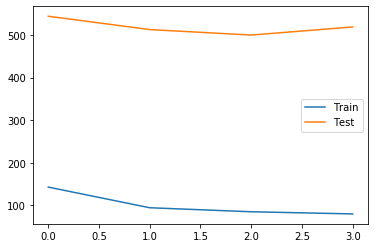

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Test'])

Plotting the errors for each field below shows that the 'y' coordinates for each figure generally have the largest error and the errors growing rapidly approaching the tips of the fingers.

In [23]:
preds = model.predict(features)

In [31]:
len(df.columns) - 8

64

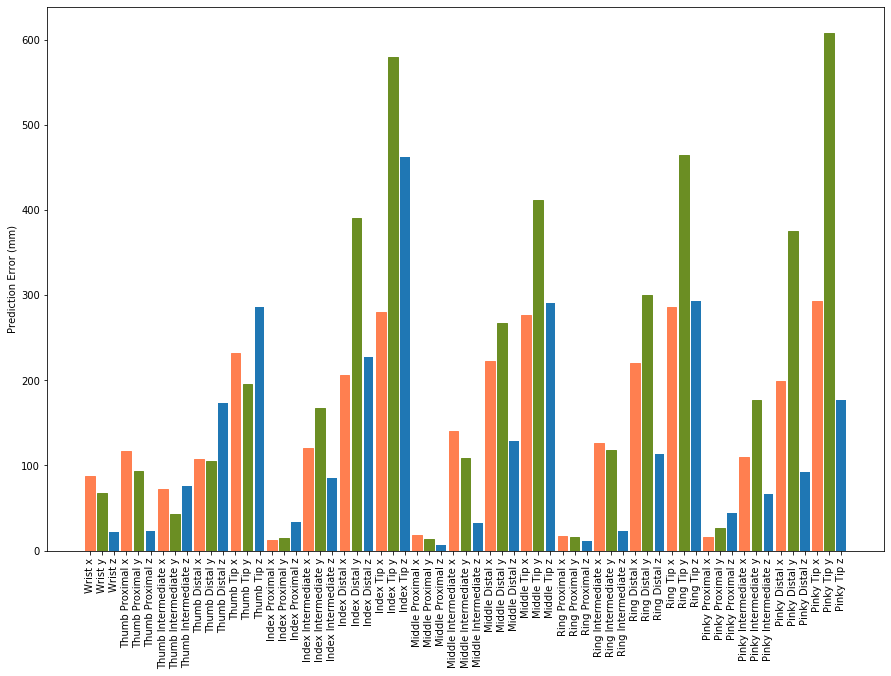

In [40]:
df.columns
error = labels - preds
sq_error = error * error
avg_error = np.mean(sq_error, axis=0)
plt.figure(figsize=(15, 10))
plt.xticks(rotation=90)
plt.ylabel('Prediction Error (mm)')
bar = plt.bar(df.columns[8:], avg_error)
for i in range(0,63,3):
    bar[i].set_color('coral')
    bar[i+1].set_color('olivedrab')
plt.show()

## LSTM with Fully Connected Layers
Below is a test using a model with several dense layers after the LSTM layers, instead of using the pretrained autoencoder.

In [41]:
model_fc = tf.keras.models.Sequential()
model_fc.add(LSTM(64, return_sequences=True, input_shape=(seq_length, 8)))
model_fc.add(Dropout(0.2))
model_fc.add(LSTM(64))
model_fc.add(BatchNormalization())
model_fc.add(Dense(100, input_dim=64))
model_fc.add(Activation('relu'))
model_fc.add(BatchNormalization())
model_fc.add(Dropout(0.2))
model_fc.add(Dense(64, input_dim=64))
model_fc.add(Activation('relu'))
model_fc.add(Dropout(0.2))
model_fc.add(Dense(63, input_dim=64))

model_fc.compile(optimizer='Adam', loss='mse')

history = model_fc.fit(features, labels, batch_size=seq_length, epochs=5, verbose=1, validation_split=0.2)

Train on 328539 samples, validate on 82135 samples
Epoch 1/5
328539/328539 [==============================] - 393s 1ms/sample - loss: 191.4491 - val_loss: 547.5092
Epoch 2/5
328539/328539 [==============================] - 385s 1ms/sample - loss: 123.6813 - val_loss: 544.5603
Epoch 3/5
328539/328539 [==============================] - 399s 1ms/sample - loss: 111.5172 - val_loss: 521.8670
Epoch 4/5
328539/328539 [==============================] - 398s 1ms/sample - loss: 104.4597 - val_loss: 490.8937
Epoch 5/5
328539/328539 [==============================] - 395s 1ms/sample - loss: 100.1914 - val_loss: 550.8656


In [ ]:
model_fc.save('FC_model.h5')

### Visual Model Error

In [42]:
preds = model_fc.predict(features)

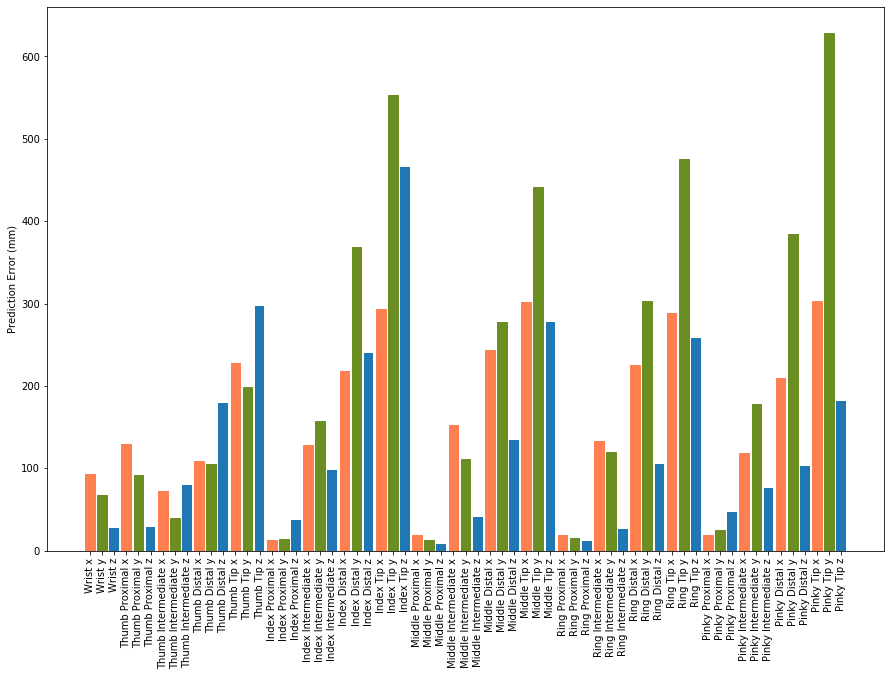

In [43]:
error = labels - preds
sq_error = error * error
avg_error = np.mean(sq_error, axis=0)
plt.figure(figsize=(15, 10))
plt.xticks(rotation=90)
plt.ylabel('Prediction Error (mm)')
bar = plt.bar(df.columns[8:], avg_error)
for i in range(0,63,3):
    bar[i].set_color('coral')
    bar[i+1].set_color('olivedrab')
plt.show()

## Training the Model On Tips Only
In an attempt to improve the accuracy of prediction of the fingertips the above models are modified and trained only using the fingertip position data to understand if this simplification yields an improvement. This is done on both of the architectures tested above.

### Autoencoder Architecture

In [ ]:
encoding_dim = 9 #dimensionality of 'feature' vector

a_fn = None

# Full autoencoder
input_vec = Input(shape=(18,))
dense_0 = Dense(32, activation=a_fn)(input_vec)
dense_1 = Dense(16, activation=a_fn)(dense_0)
encoded = Dense(encoding_dim, activation=a_fn)(dense_1)
dense_2 = Dense(32, activation=a_fn, name='decoder_0')(encoded)
dense_3 = Dense(16, activation=a_fn, name='decoder_1')(dense_2)
decoded = Dense(18, activation=a_fn, name='decoder_output')(dense_3)

autoencoder = Model(input_vec, decoded)

# Encoder from autoencoder
encoder = Model(input_vec, encoded)

# Decoder from autoencoder layers
decoder_input = Input(shape=(encoding_dim,), name='encoded_input')
decode_0 = autoencoder.layers[-3](decoder_input)
decode_1 = autoencoder.layers[-2](decode_0)
decode_output = autoencoder.layers[-1](decode_1)
decoder = Model(decoder_input, decode_output, name='decoder')

# Train Autoencoder
optimizer = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
autoencoder.compile(optimizer=optimizer, loss='mean_squared_error')

In [44]:
label_ar_t = label_ar[:,[0,1,2,12,13,14,24,25,26,36,37,38,48,49,50,60,61,62]]
label_ar_t.shape

(410705, 18)

In [ ]:
ret = autoencoder.fit(label_ar_t, label_ar_t, batch_size=512, epochs=30, verbose=1, validation_split=0.2)

Create a smaller labels vector with only the tip and wrist x,y,z:

In [47]:
labels_tip = labels[:,[0,1,2,12,13,14,24,25,26,36,37,38,48,49,50,60,61,62]]
labels_tip.shape

(410674, 18)

In [ ]:
#lstm layers
inputs = Input(shape=(None, 8), name="inputs")
lstm_0 = LSTM(64, return_sequences=True, name="lstm_0")(inputs)
do = Dropout(0.2)(lstm_0)
lstm_1 = LSTM(64, return_sequences=False, name="lstm_1")(do)
lstm_out = Dense(9, activation=None, name="lstm_out")(lstm_1)

#decoder layers
decoder_0 = decoder.get_layer("decoder_0")(lstm_out)
decoder_0.trainable = False
decoder_1 = decoder.get_layer("decoder_1")(decoder_0)
decoder_1.trainable = False
decoder_output = decoder.get_layer("decoder_output")(decoder_1)
decoder_output.trainable = False

model = Model(inputs, decoder_output, name="model_v1")
optimizer = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.00, amsgrad=False)
model.compile(optimizer=optimizer, loss='mse')
model.summary()

In [ ]:
history = model.fit(features, labels_tip, batch_size=seq_length, epochs=1, verbose=1, validation_split=0.2)

### Visual Model Error
Model error for the reduced Autoencoder architecture:

In [ ]:
preds = model.predict(features)

In [ ]:
error = labels_tip - preds
sq_error = error * error
avg_error = np.mean(sq_error, axis=0)
plt.figure(figsize=(15, 10))
plt.xticks(rotation=90)
plt.ylabel('Prediction Error (mm)')
bar = plt.bar(df.columns[8:][[0,1,2,12,13,14,24,25,26,36,37,38,48,49,50,60,61,62]], avg_error)
for i in range(0,18,3):
    bar[i].set_color('coral')
    bar[i+1].set_color('olivedrab')
plt.show()

### Tips only with FC Architecture

In [52]:
model_fc = tf.keras.models.Sequential()
model_fc.add(LSTM(64, return_sequences=True, input_shape=(seq_length, 8)))
model_fc.add(Dropout(0.2))
model_fc.add(LSTM(64))
model_fc.add(BatchNormalization())
model_fc.add(Dense(100, input_dim=64))
model_fc.add(Activation('relu'))
model_fc.add(BatchNormalization())
model_fc.add(Dropout(0.2))
model_fc.add(Dense(64, input_dim=64))
model_fc.add(Activation('relu'))
model_fc.add(Dropout(0.2))
model_fc.add(Dense(18, input_dim=64))

model_fc.compile(optimizer='Adam', loss='mse')

history = model_fc.fit(features, labels_tip, batch_size=2000, epochs=6, verbose=1, validation_split=0.2)

Train on 328539 samples, validate on 82135 samples
Epoch 1/6
328539/328539 [==============================] - 140s 425us/sample - loss: 1753.7825 - val_loss: 1738.9338
Epoch 2/6
328539/328539 [==============================] - 132s 401us/sample - loss: 493.1359 - val_loss: 1348.2002
Epoch 3/6
328539/328539 [==============================] - 130s 395us/sample - loss: 428.6101 - val_loss: 1295.7310
Epoch 4/6
328539/328539 [==============================] - 130s 394us/sample - loss: 386.0151 - val_loss: 1107.5072
Epoch 5/6
328539/328539 [==============================] - 135s 411us/sample - loss: 347.9416 - val_loss: 953.5972
Epoch 6/6
328539/328539 [==============================] - 132s 403us/sample - loss: 315.1996 - val_loss: 1038.9055


### Visual Model Error
A similar visualizion is now done on this new more restricted model. These errors show 20% - 25% improvement on fingertip y position.

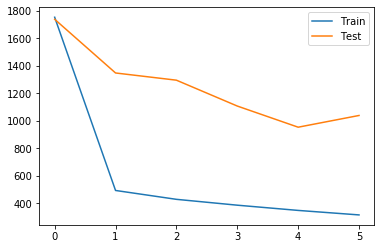

In [53]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Test'])

In [54]:
preds = model_fc.predict(features)

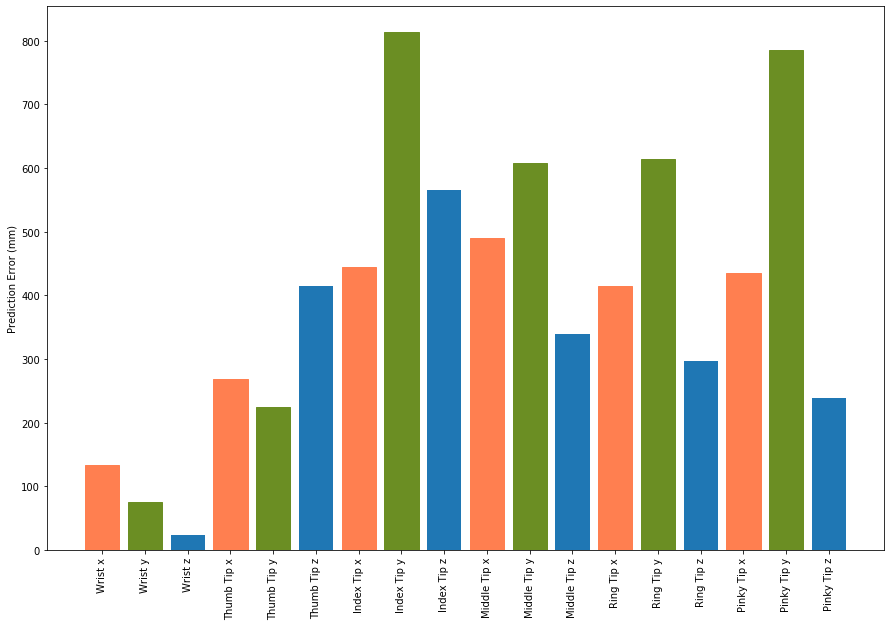

In [55]:
error = labels_tip - preds
sq_error = error * error
avg_error = np.mean(sq_error, axis=0)
plt.figure(figsize=(15, 10))
plt.xticks(rotation=90)
plt.ylabel('Prediction Error (mm)')
bar = plt.bar(df.columns[8:][[0,1,2,12,13,14,24,25,26,36,37,38,48,49,50,60,61,62]], avg_error)
for i in range(0,18,3):
    bar[i].set_color('coral')
    bar[i+1].set_color('olivedrab')
plt.show()